In [50]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn

# 加载CSV文件
data = pd.read_csv('/Users/curryyang/code/2024_MCM_C_UESTC/processed_datasets/male_processed.csv')  # 确保这里的路径是正确的
data_1 = pd.read_csv('/Users/curryyang/Downloads/p1_status_performance.csv')
data_2 = pd.read_csv('/Users/curryyang/Downloads/p2_status_performance.csv')
data['p1_performance'] = data_1['p1_performance']
data['p2_performance'] = data_2['p2_performance']   

# 提取指定行的数据
rows_to_use = list(range(1, 302)) + list(range(3790, 4015)) + list(range(5709, 5898)) + list(range(6591, 6750))
rows_to_use_1 = list(range(3623, 3789)) + list(range(5438, 5708)) + list(range(6374, 6590)) + list(range(6750, 6951))
train_data = data.iloc[rows_to_use]
train_data_1 = data.iloc[rows_to_use_1]

# 测试集 - 最后一场比赛的数据
test_data = data.iloc[6952:7286]

train_scores = train_data['p1_performance'].values
test_scores = test_data['p1_performance'].values

train_scores_1 = train_data_1['p2_performance'].values
test_scores_1 = test_data['p2_performance'].values

# 数据归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scores_normalized = scaler.fit_transform(train_scores.reshape(-1, 1))
test_scores_normalized = scaler.transform(test_scores.reshape(-1, 1))
# 数据归一化plaer2
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scores_normalized_1 = scaler.fit_transform(train_scores_1.reshape(-1, 1))
test_scores_normalized_1 = scaler.transform(test_scores_1.reshape(-1, 1))
# 转换为PyTorch张量
train_scores_normalized = torch.FloatTensor(train_scores_normalized).view(-1)
test_scores_normalized = torch.FloatTensor(test_scores_normalized).view(-1)
# 转换为PyTorch张量player2
train_scores_normalized_1 = torch.FloatTensor(train_scores_normalized_1).view(-1)
test_scores_normalized_1 = torch.FloatTensor(test_scores_normalized_1).view(-1)


In [51]:
class CNNLSTMModel(nn.Module):
    def __init__(self, hidden_layer_size=50):
        super(CNNLSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size  # 添加hidden_layer_size属性
        
        # 定义模型层
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.lstm = nn.LSTM(input_size=64, hidden_size=self.hidden_layer_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_layer_size, out_features=1)

    def forward(self, x):
        #x = x.unsqueeze(1)  # 添加channel维度
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.transpose(1, 2)  # 调整维度以适应LSTM的输入要求
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])  # 只使用序列的最后一个输出
        return predictions


In [52]:
# 定义训练数据加载器
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# 设定时间窗口大小
train_window = 5
test_window = 5

# 创建训练序列
train_inout_seq = create_inout_sequences(train_scores_normalized, train_window)
test_inout_seq = create_inout_sequences(test_scores_normalized, test_window)
# 创建训练序列player2
train_inout_seq_1 = create_inout_sequences(train_scores_normalized_1, train_window)
test_inout_seq_1 = create_inout_sequences(test_scores_normalized_1, test_window)



In [53]:
def train_model(model, train_inout_seq, epochs=10, lr=0.001):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []  # 用于收集每个epoch的损失值

    for epoch in range(epochs):
        total_loss = 0
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            seq = seq.view(-1, 1, train_window)
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
            total_loss += single_loss.item()
        
        avg_loss = total_loss / len(train_inout_seq)
        losses.append(avg_loss)
        print(f'epoch: {epoch+1} loss: {avg_loss:.8f}')
    
    return losses


/Users/curryyang/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 1 loss: 0.27151326
epoch: 2 loss: 0.26105637
epoch: 3 loss: 0.25728806
epoch: 4 loss: 0.25503235
epoch: 5 loss: 0.25324014
epoch: 6 loss: 0.25166805
epoch: 7 loss: 0.25007321
epoch: 8 loss: 0.24842493
epoch: 9 loss: 0.24670371
epoch: 10 loss: 0.24496688
epoch: 11 loss: 0.24308931
epoch: 12 loss: 0.24107536
epoch: 13 loss: 0.23892433
epoch: 14 loss: 0.23655574
epoch: 15 loss: 0.23416064
epoch: 16 loss: 0.23171028
epoch: 17 loss: 0.22922230
epoch: 18 loss: 0.22677517
epoch: 19 loss: 0.22438986
epoch: 20 loss: 0.22207274
epoch: 21 loss: 0.21979275
epoch: 22 loss: 0.21751803
epoch: 23 loss: 0.21532440
epoch: 24 loss: 0.21308492
epoch: 25 loss: 0.21087878
epoch: 26 loss: 0.20855988
epoch: 27 loss: 0.20618303
epoch: 28 loss: 0.20369045
epoch: 29 loss: 0.20124287
epoch: 30 loss: 0.19856432
epoch: 31 loss: 0.19590099
epoch: 32 loss: 0.19308672
epoch: 33 loss: 0.19014607
epoch: 34 loss: 0.18708708
epoch: 35 loss: 0.18384817
epoch: 36 loss: 0.18020459
epoch: 37 loss: 0.17678282
epoch: 38 

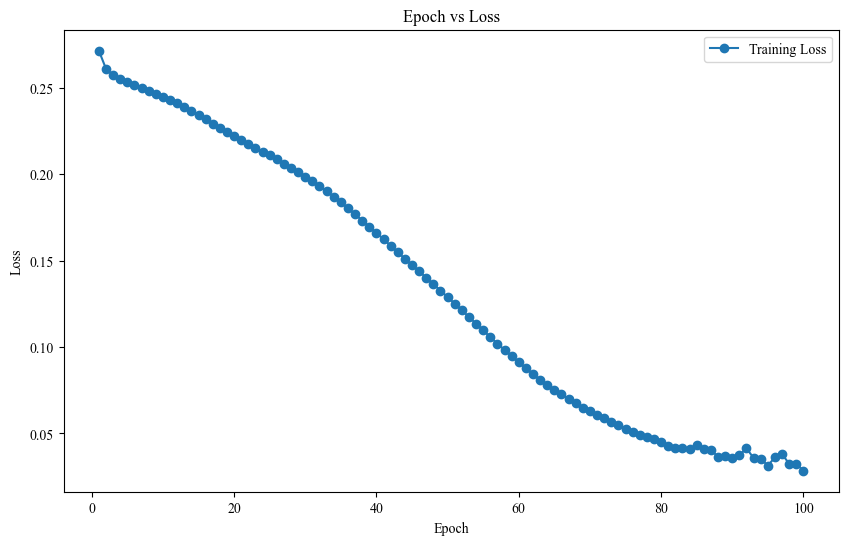

In [54]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Times New Roman'

# 实例化并训练模型
model = CNNLSTMModel()
losses = train_model(model, train_inout_seq, epochs=100, lr=0.001)

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses)+1), losses, marker='o', label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


epoch: 1 loss: 0.23947277
epoch: 2 loss: 0.23317807
epoch: 3 loss: 0.23044976
epoch: 4 loss: 0.22791049
epoch: 5 loss: 0.22567201
epoch: 6 loss: 0.22388978
epoch: 7 loss: 0.22238082
epoch: 8 loss: 0.22104216
epoch: 9 loss: 0.21981152
epoch: 10 loss: 0.21864219
epoch: 11 loss: 0.21749206
epoch: 12 loss: 0.21634447
epoch: 13 loss: 0.21522621
epoch: 14 loss: 0.21413445
epoch: 15 loss: 0.21306658
epoch: 16 loss: 0.21203996
epoch: 17 loss: 0.21104687
epoch: 18 loss: 0.20995265
epoch: 19 loss: 0.20888812
epoch: 20 loss: 0.20778883
epoch: 21 loss: 0.20660349
epoch: 22 loss: 0.20544225
epoch: 23 loss: 0.20416843
epoch: 24 loss: 0.20287728
epoch: 25 loss: 0.20138786
epoch: 26 loss: 0.19974271
epoch: 27 loss: 0.19794732
epoch: 28 loss: 0.19615740
epoch: 29 loss: 0.19419955
epoch: 30 loss: 0.19221729
epoch: 31 loss: 0.19025799
epoch: 32 loss: 0.18810313
epoch: 33 loss: 0.18588829
epoch: 34 loss: 0.18370701
epoch: 35 loss: 0.18141539
epoch: 36 loss: 0.17901216
epoch: 37 loss: 0.17649703
epoch: 38 

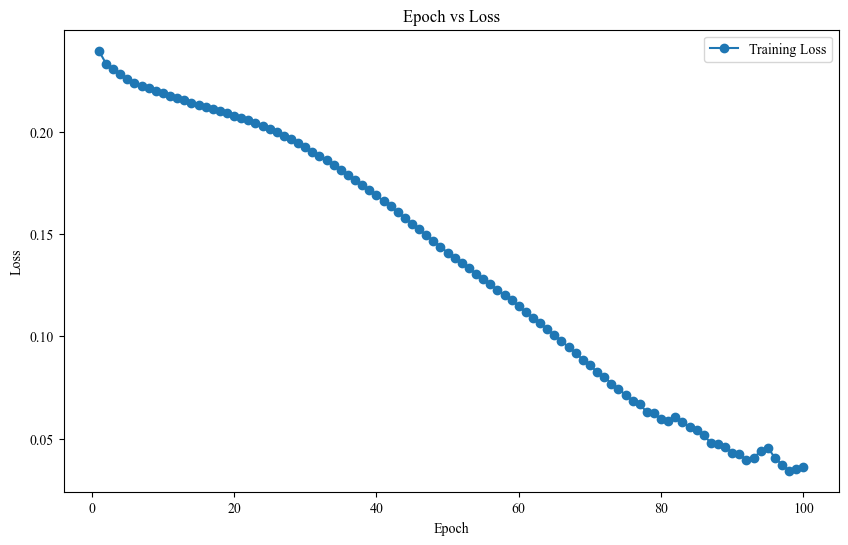

In [55]:
# 实例化并训练模型player2
import matplotlib.pyplot as plt

# 实例化并训练模型
model_1 = CNNLSTMModel()
losses_1 = train_model(model_1, train_inout_seq_1, epochs=100, lr=0.001)

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses_1)+1), losses_1, marker='o', label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

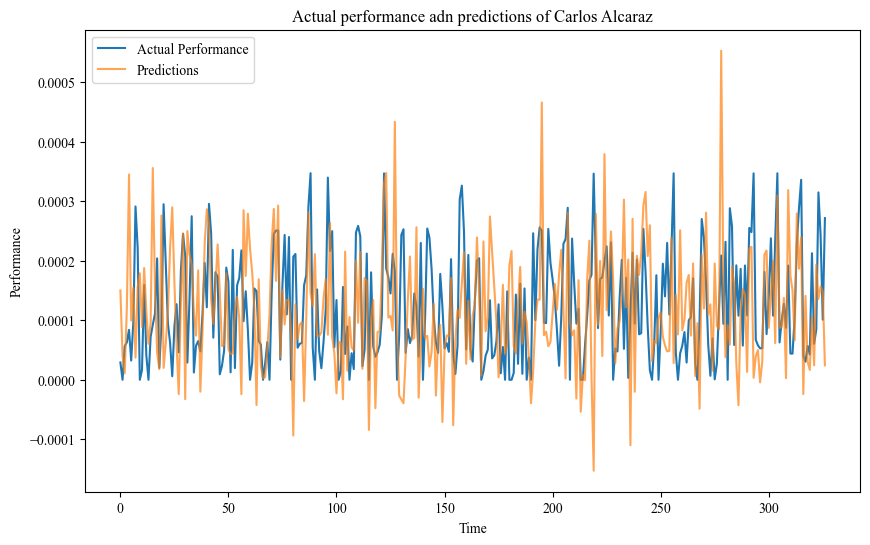

In [59]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for seq, true_val in test_inout_seq:  # 确保test_inout_seq已准备好
        seq = seq.view(-1, 1, train_window)
        prediction = model(seq)
        prediction = scaler.inverse_transform(prediction.numpy().reshape(-1, 1))
        true_val = scaler.inverse_transform(true_val.numpy().reshape(-1, 1))

        # 检查prediction是否包含多个值
        if prediction.size > 1:
            predictions.extend(prediction.squeeze().tolist())
        else:
            predictions.append(prediction.item())  # 直接添加单个预测值

        # 对于实际值执行相同的检查
        if true_val.size > 1:
            actuals.extend(true_val.squeeze().tolist())
        else:
            actuals.append(true_val.item())

# 绘制测试集拟合曲线
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Performance')
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.title('Actual performance adn predictions of Carlos Alcaraz')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()


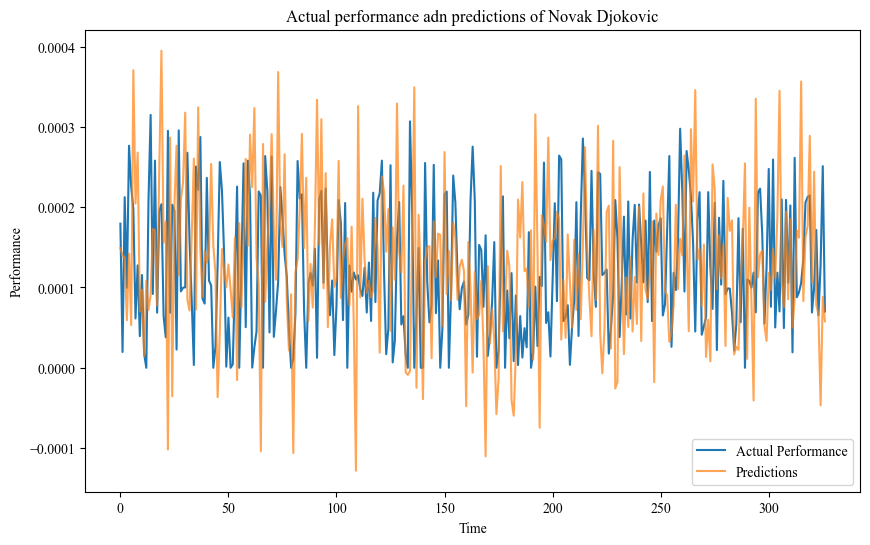

In [60]:
model_1.eval()
predictions_1 = []
actuals_1 = []

with torch.no_grad():
    for seq, true_val in test_inout_seq_1:  # 确保test_inout_seq已准备好
        seq = seq.view(-1, 1, train_window)
        prediction = model_1(seq)
        prediction = scaler.inverse_transform(prediction.numpy().reshape(-1, 1))
        true_val = scaler.inverse_transform(true_val.numpy().reshape(-1, 1))

        # 检查prediction是否包含多个值
        if prediction.size > 1:
            predictions_1.extend(prediction.squeeze().tolist())
        else:
            predictions_1.append(prediction.item())  # 直接添加单个预测值

        # 对于实际值执行相同的检查
        if true_val.size > 1:
            actuals_1.extend(true_val.squeeze().tolist())
        else:
            actuals_1.append(true_val.item())

# 绘制测试集拟合曲线
plt.figure(figsize=(10, 6))
plt.plot(actuals_1, label='Actual Performance')
plt.plot(predictions_1, label='Predictions', alpha=0.7)
plt.title('Actual performance adn predictions of Novak Djokovic')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()


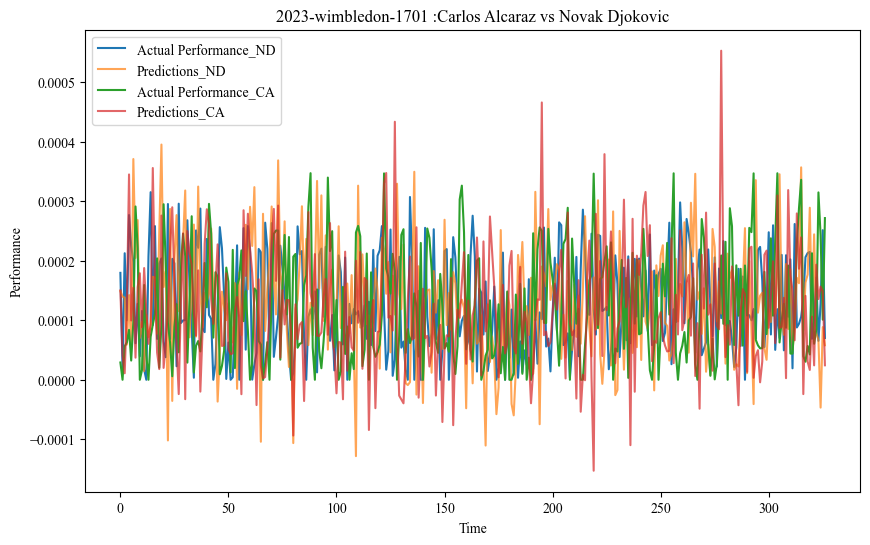

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(actuals_1, label='Actual Performance_ND')
plt.plot(predictions_1, label='Predictions_ND', alpha=0.7)
plt.plot(actuals, label='Actual Performance_CA')
plt.plot(predictions, label='Predictions_CA', alpha=0.7)
plt.title('2023-wimbledon-1701 :Carlos Alcaraz vs Novak Djokovic')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()